<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-A01793817/blob/main/kmeans_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Datos generales:**

Nombre de la entrega: K means

Nombre: Javier Antonio Rodríguez Rudas

Matrícula: A01793817

Materia: Ciencia de datos

Profesor: Dra. María de la Paz Rico Fernádez

Fecha: 09-Nov-2022

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [ ]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 681 kB/s 
     |████████████████████████████████| 1.0 MB 30.9 MB/s 
     |████████████████████████████████| 1.7 MB 38.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 42.0 MB/s 
     |████████████████████████████████| 6.3 MB 48.1 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27812 sha256=5074061629e77ba7ead446e2f1567ef42d18b19fbad3990b61a2c42a6f4979c6
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=4082bd3350e1bca0c08cb0bbd7f73c57d7e107b435a174e242b40b0b1afc9200
  Stored in directory: /root/.

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [ ]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [ ]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [ ]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

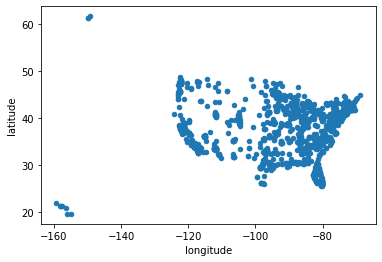

In [ ]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [ ]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [ ]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [ ]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [ ]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [ ]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

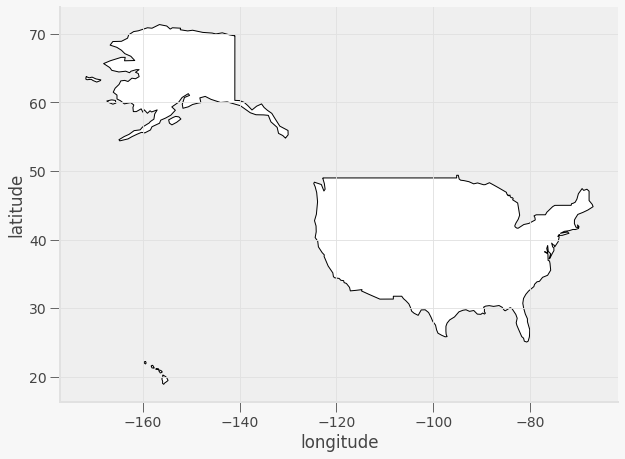

In [ ]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

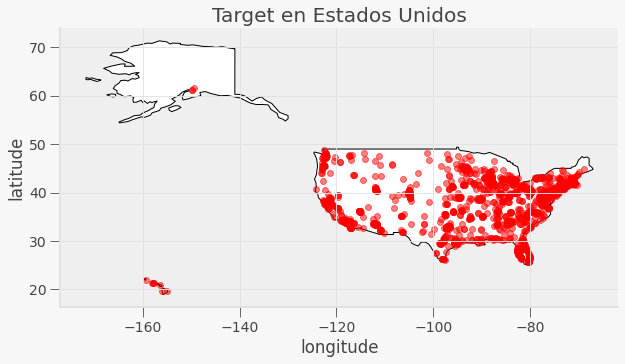

In [ ]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

Vamos a hallar el valor de K haciendo una gráfica e intentando hallar el “punto de codo” que comentábamos antes. Este es nuestro resultado:

In [ ]:
#tu codigo aquí
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim

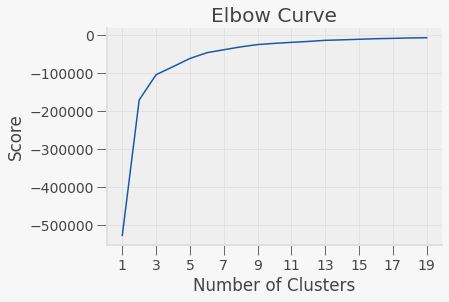

In [ ]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(latlong).score(latlong) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.xticks(np.arange(min(Nc), max(Nc)+1, 2.0))
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

De acuerdo con la curva anterior, se puede observar que el score deja de tener cambios tan grandes entre un número de clusters de 5 y 6. Sin embargo, al intentar realizar el k-means con 6 clusters, uno de los centroides se va a lo que parece ser el mar o algún otro país, por lo que tal vez no sería lo más conveiente. Debido a eso, se seleccionó una k o número de almacenes de 5.

In [ ]:
kmeans = KMeans(n_clusters=5).fit(latlong)
centroids = kmeans.cluster_centers_

In [ ]:
C_df= pd.DataFrame({'longitude': centroids[:, 1],'latitude': centroids[:, 0]})
C_df["Coordinates"] = list(zip(C_df.longitude, C_df.latitude))
C_df["Coordinates"] = C_df["Coordinates"].apply(Point)
C_gdf = gpd.GeoDataFrame(C_df, geometry="Coordinates")
C_gdf.head()

,longitude,latitude,Coordinates
0,-82.873254,31.109013,POINT (-82.87325 31.10901)
1,-119.176343,37.579774,POINT (-119.17634 37.57977)
2,-75.585080,40.343655,POINT (-75.58508 40.34366)
3,-88.354978,41.759636,POINT (-88.35498 41.75964)
4,-98.217846,34.393459,POINT (-98.21785 34.39346)


In [ ]:
geolocator = Nominatim(user_agent="geoapiExercises")

In [ ]:
def city_state_country(row):
    coord = f"{row['latitude']}, {row['longitude']}"
    location = geolocator.reverse(coord, exactly_one=True)
    address = location.raw['address']
    city = address.get('city', '')
    state = address.get('state', '')
    zip_code = address.get('postcode', '')
    country = address.get('country', '')
    row['city'] = city
    row['state'] = state
    row['country'] = country
    row['postcode'] = zip_code
    return row

C_df = C_df.apply(city_state_country, axis=1)
C_df.head()

,longitude,latitude,Coordinates,city,state,country,postcode
0,-82.873254,31.109013,POINT (-82.87325376457564 31.109013321402216),,Georgia,United States,
1,-119.176343,37.579774,POINT (-119.17634307255436 37.57977423831522),,California,United States,
2,-75.585080,40.343655,POINT (-75.58507975156577 40.34365501878914),Douglass Township,Pennsylvania,United States,19525
3,-88.354978,41.759636,POINT (-88.35497835200945 41.759635800945624),Aurora,Illinois,United States,60506
4,-98.217846,34.393459,POINT (-98.21784622651006 34.39345929463087),,Oklahoma,United States,


Con ayuda de la API Nominatim, podemos ver el estado en el que se encontrarían los almacenes, así como la ciudad en algunos casos.

Los estados serían: Pennsylvania, California, Georgia, Oklahoma e Illinois.

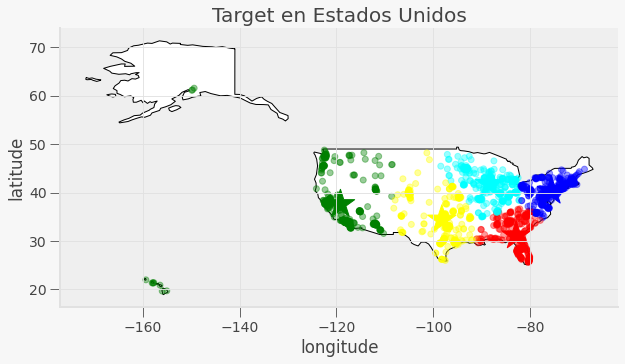

In [ ]:
labels = kmeans.predict(latlong)
colores=['red','green','blue','cyan','yellow'] #,'maroon'
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig, gax = plt.subplots(figsize=(10,10))

world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

gdf.plot(ax=gax, color=asignar, alpha = 0.4)
C_gdf.plot(ax=gax, color=colores, marker='*', markersize=900)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()


In [ ]:
copy =  pd.DataFrame()
copy['latitude']=latlong['latitude'].values
copy['longitude']=latlong['longitude'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['estado']= C_df['state']
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,estado,color,cantidad
0,Georgia,red,272
1,California,green,368
2,Pennsylvania,blue,480
3,Illinois,cyan,422
4,Oklahoma,yellow,297


En la tabla de arriba vemos la distribución de tiendas que serían surtidas por cada alamacen. Podemos notar que los alamacenes de Pennsylvania e Illinois tendrían los productos de una mayor cantidad de tiendas, por lo que tal vez sería conveniente invertir en lugares de mayor tamaño.

Visualizar datos geográficos en un mapa es importante sobre todo cuando no se tiene conocimiento total de lo que se está graficando. En las primeras gráficas de este ejercicio veíamos que había puntos alejados de los demás, lo cual podría parecer extraño si no se sabe que Estados Unidos tiene territorios despegados del resto como por ejemplo el estado de Alaska.

Además de la librería GeoPandas, la cual fue usada en este ejercicio, existen otras librerías que también puede ser bastante útiles para trabajar con este tipo de datos. Está la librería Fiona que sirve para la lectura y escritura de archivos geométricos de tipo vectorial y la librería ORG que se usa para leer y convertir datos de Sistema de Integración Geográfica (GIS) de carácter vectorial.